#1. Settings

In [ ]:
import os
from zipfile import ZipFile
import struct
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Check TPU connection and settings

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.61.33.26:8470']


#2. Create datasets with TFRecords

Create Datasets from TFRecords. The records were for training, validation, testing and final training with both training and validation data. All data were uploaded in Google Cloud for using TPU in this case.

In [ ]:
# filepath (Google Cloud to use TPU in this case)

filepath_train = 'gs://sabiko_project/956_train.tfrecord'
filepath_val = 'gs://sabiko_project/956_val.tfrecord'
filepath_test = 'gs://sabiko_project/956_test.tfrecord'
filepath_train_val = 'gs://sabiko_project/956_train_validation.tfrecord'

In [ ]:
batch_size = 1024
AUTOTUNE = tf.data.AUTOTUNE

# function transforming TFRecord data into a format usable by TensorFlow models.
def parse_batch_example(example):
    features = tf.io.parse_example(example, features={
        "image": tf.io.FixedLenFeature([127, 128, 1], dtype=tf.float32),
        "label": tf.io.FixedLenFeature([956,], dtype=tf.float32)
    })
    x = features["image"]
    y = features["label"]
    return x, y

# create dataset from TFRecords (with shuffle, prefetch)
dataset_train = tf.data.TFRecordDataset(filepath_train, num_parallel_reads=AUTOTUNE).shuffle(1000).batch(batch_size).map(parse_batch_example).prefetch(AUTOTUNE)
dataset_val = tf.data.TFRecordDataset(filepath_val, num_parallel_reads=AUTOTUNE).shuffle(1000).batch(batch_size).map(parse_batch_example).prefetch(AUTOTUNE)
dataset_test = tf.data.TFRecordDataset(filepath_test, num_parallel_reads=AUTOTUNE).shuffle(1000).batch(batch_size).map(parse_batch_example).prefetch(AUTOTUNE)
dataset_train_val = tf.data.TFRecordDataset(filepath_train, num_parallel_reads=AUTOTUNE).shuffle(1000).batch(batch_size).map(parse_batch_example).prefetch(AUTOTUNE)

 # 3. Build Dense Network Models

## 3.1 Initial 2-hidden layer model

In [ ]:
import keras
from keras import layers

def create_model():

  inputs = keras.Input(shape=(127,128,1))
  x = layers.Flatten()(inputs)

  x = layers.Dense(1024, activation='relu')(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 flatten (Flatten)           (None, 16256)             0         
                                                                 
 dense (Dense)               (None, 1024)              16647168  
                                                                 
 dense_1 (Dense)             (None, 956)               979900    
                                                                 
Total params: 17,627,068
Trainable params: 17,627,068
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True) # Early stop if val_loss sees no improvement

Train

In [ ]:
history = model.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=50,
  callbacks=[callback]
)

Epoch 1/50
131/131 [==============================] - 89s 609ms/step - loss: 5.0988 - accuracy: 0.1520 - val_loss: 3.5792 - val_accuracy: 0.3347
Epoch 2/50
131/131 [==============================] - 14s 108ms/step - loss: 2.8372 - accuracy: 0.4651 - val_loss: 2.6830 - val_accuracy: 0.4766
Epoch 3/50
131/131 [==============================] - 11s 86ms/step - loss: 2.1815 - accuracy: 0.5747 - val_loss: 2.3672 - val_accuracy: 0.5286
Epoch 4/50
131/131 [==============================] - 11s 83ms/step - loss: 1.8015 - accuracy: 0.6422 - val_loss: 2.1225 - val_accuracy: 0.5721
Epoch 5/50
131/131 [==============================] - 12s 90ms/step - loss: 1.5020 - accuracy: 0.6978 - val_loss: 1.9505 - val_accuracy: 0.5956
Epoch 6/50
131/131 [==============================] - 11s 84ms/step - loss: 1.2484 - accuracy: 0.7484 - val_loss: 1.7976 - val_accuracy: 0.6209
Epoch 7/50
131/131 [==============================] - 11s 82ms/step - loss: 1.0344 - accuracy: 0.7934 - val_loss: 1.6693 - val_accurac

Plot

In [ ]:
def plot_loss(x):

    history_dict = x.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

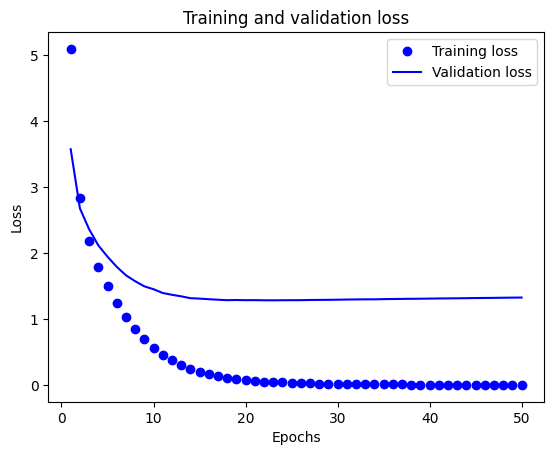

In [ ]:
plot_loss(history)

Test accuracy

In [ ]:
model1_loss, model1_acc = model.evaluate(dataset_test)

print('mode1_acc:', model1_acc)

10/10 [==============================] - 7s 160ms/step - loss: 1.2824 - accuracy: 0.7544
mode1_acc: 0.7544000148773193


## 3.2 Add a dense layer to see overfiting

In [ ]:
import keras
from keras import layers

def create_model2():

  inputs = keras.Input(shape=(127,128,1))
  x = layers.Flatten()(inputs)

  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dense(1024, activation='relu')(x) # added

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model2 = create_model2()
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 16256)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              16647168  
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 956)               979900    
                                                                 
Total params: 18,676,668
Trainable params: 18,676,668
Non-trainable params: 0
_________________________________________________________________


Train

In [ ]:
history = model2.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=50,
  callbacks=[callback],
)

Epoch 1/50
131/131 [==============================] - 32s 132ms/step - loss: 5.4140 - accuracy: 0.0816 - val_loss: 3.9926 - val_accuracy: 0.2150
Epoch 2/50
131/131 [==============================] - 12s 87ms/step - loss: 2.9961 - accuracy: 0.3870 - val_loss: 2.4964 - val_accuracy: 0.4615
Epoch 3/50
131/131 [==============================] - 11s 83ms/step - loss: 1.9180 - accuracy: 0.5748 - val_loss: 1.8763 - val_accuracy: 0.5685
Epoch 4/50
131/131 [==============================] - 11s 84ms/step - loss: 1.2768 - accuracy: 0.7009 - val_loss: 1.3776 - val_accuracy: 0.6769
Epoch 5/50
131/131 [==============================] - 11s 85ms/step - loss: 0.8771 - accuracy: 0.7867 - val_loss: 1.1520 - val_accuracy: 0.7200
Epoch 6/50
131/131 [==============================] - 12s 89ms/step - loss: 0.5937 - accuracy: 0.8524 - val_loss: 0.9553 - val_accuracy: 0.7622
Epoch 7/50
131/131 [==============================] - 11s 84ms/step - loss: 0.4048 - accuracy: 0.8995 - val_loss: 0.8760 - val_accuracy

Plot

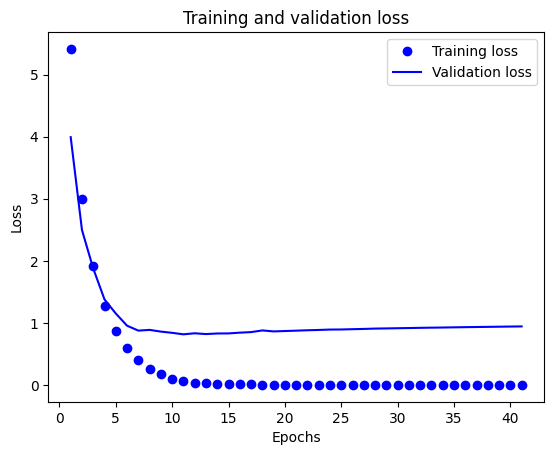

In [ ]:
plot_loss(history)

The graph above showed a gradual increase in validation loss with epochs (not clear, though).

Test accuracy

In [ ]:
model1_loss, model1_acc = model2.evaluate(dataset_test)

print('mode12_acc:', model1_acc)

10/10 [==============================] - 4s 63ms/step - loss: 0.7961 - accuracy: 0.8212
mode12_acc: 0.8212000131607056


## 3.3 Add Dropout

Use dropout before the last dense layer with 956 units to mitigate overfitting. The dropout rate was 0.5.

In [ ]:
import keras
from keras import layers

def create_model3():

  inputs = keras.Input(shape=(127,128,1))
  x = layers.Flatten()(inputs)

  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dense(1024, activation='relu')(x)

  x = layers.Dropout(0.5)(x) # dropout (rate of 0.5)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope():
  model3 = create_model3()
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 flatten_2 (Flatten)         (None, 16256)             0         
                                                                 
 dense_5 (Dense)             (None, 1024)              16647168  
                                                                 
 dense_6 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 956)               979900    
                                                                 
Total params: 18,676,668
Trainable params: 18,676,668
Non-t

Train

In [ ]:
history3 = model3.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=100,
  callbacks=[callback]
)

Epoch 1/100
131/131 [==============================] - 27s 141ms/step - loss: 5.8564 - accuracy: 0.0394 - val_loss: 4.3370 - val_accuracy: 0.1879
Epoch 2/100
131/131 [==============================] - 11s 85ms/step - loss: 3.6903 - accuracy: 0.2601 - val_loss: 2.5934 - val_accuracy: 0.4708
Epoch 3/100
131/131 [==============================] - 12s 87ms/step - loss: 2.4846 - accuracy: 0.4574 - val_loss: 1.9111 - val_accuracy: 0.5757
Epoch 4/100
131/131 [==============================] - 11s 87ms/step - loss: 1.7919 - accuracy: 0.5848 - val_loss: 1.4251 - val_accuracy: 0.6751
Epoch 5/100
131/131 [==============================] - 11s 84ms/step - loss: 1.3275 - accuracy: 0.6775 - val_loss: 1.1556 - val_accuracy: 0.7229
Epoch 6/100
131/131 [==============================] - 12s 90ms/step - loss: 1.0129 - accuracy: 0.7470 - val_loss: 0.9618 - val_accuracy: 0.7613
Epoch 7/100
131/131 [==============================] - 12s 87ms/step - loss: 0.7893 - accuracy: 0.7957 - val_loss: 0.8807 - val_a

Plot

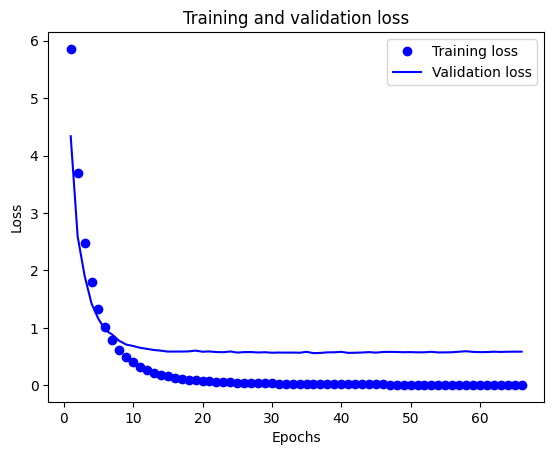

In [ ]:
plot_loss(history3)

No apparent overfitting was implied.

Test accuracy

In [ ]:
model1_loss, model1_acc = model3.evaluate(dataset_test)

print('mode13_acc:', model1_acc)

10/10 [==============================] - 2s 65ms/step - loss: 0.5463 - accuracy: 0.8725
mode13_acc: 0.8725000023841858


## 3.4 Add Dense layers

### 3.4.1 Three hidden dense layers with units of 1024

In [ ]:
def create_model4():

  inputs = keras.Input(shape=(127,128,1))
  x = layers.Flatten()(inputs)

  for i in range(3):
    x = layers.Dense(1024, activation='relu')(x)

  x = layers.Dropout(0.5)(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model4 = create_model4()
model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 flatten_3 (Flatten)         (None, 16256)             0         
                                                                 
 dense_8 (Dense)             (None, 1024)              16647168  
                                                                 
 dense_9 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_10 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 956)               9799

Train

In [ ]:
history4 = model4.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=100,
  callbacks=[callback]
)

Epoch 1/100
131/131 [==============================] - 27s 139ms/step - loss: 6.2743 - accuracy: 0.0113 - val_loss: 5.4883 - val_accuracy: 0.0374
Epoch 2/100
131/131 [==============================] - 12s 91ms/step - loss: 4.6193 - accuracy: 0.1089 - val_loss: 3.3761 - val_accuracy: 0.2817
Epoch 3/100
131/131 [==============================] - 11s 85ms/step - loss: 3.1546 - accuracy: 0.2997 - val_loss: 2.4293 - val_accuracy: 0.4406
Epoch 4/100
131/131 [==============================] - 12s 88ms/step - loss: 2.1779 - accuracy: 0.4770 - val_loss: 1.7227 - val_accuracy: 0.5798
Epoch 5/100
131/131 [==============================] - 11s 84ms/step - loss: 1.5352 - accuracy: 0.6106 - val_loss: 1.3345 - val_accuracy: 0.6673
Epoch 6/100
131/131 [==============================] - 11s 85ms/step - loss: 1.0971 - accuracy: 0.7083 - val_loss: 1.0135 - val_accuracy: 0.7381
Epoch 7/100
131/131 [==============================] - 12s 87ms/step - loss: 0.7917 - accuracy: 0.7808 - val_loss: 0.8333 - val_a

Plot

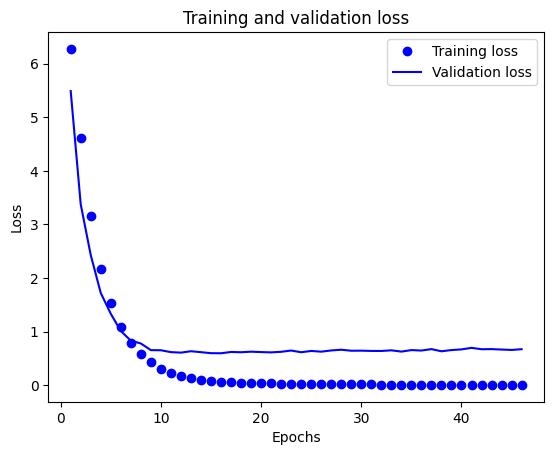

In [ ]:
plot_loss(history4)

Test accuracy

In [ ]:
model1_loss, model1_acc = model4.evaluate(dataset_test)

print('mode14_acc:', model1_acc)

10/10 [==============================] - 3s 63ms/step - loss: 0.5991 - accuracy: 0.8549
mode14_acc: 0.8549000024795532


### 3.4.1 Four hidden dense layers with units of 1024

In [ ]:
def create_model5():

  inputs = keras.Input(shape=(127,128,1))
  x = layers.Flatten()(inputs)

  for i in range(4):
    x = layers.Dense(1024, activation='relu')(x)

  x = layers.Dropout(0.5)(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model5 = create_model5()
model5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 flatten_4 (Flatten)         (None, 16256)             0         
                                                                 
 dense_12 (Dense)            (None, 1024)              16647168  
                                                                 
 dense_13 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_14 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_15 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0   

Train

In [ ]:
history5 = model5.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=100,
  callbacks=[callback]
)

Epoch 1/100
131/131 [==============================] - 31s 155ms/step - loss: 6.4830 - accuracy: 0.0040 - val_loss: 5.9434 - val_accuracy: 0.0103
Epoch 2/100
131/131 [==============================] - 11s 84ms/step - loss: 5.4806 - accuracy: 0.0261 - val_loss: 5.0272 - val_accuracy: 0.0471
Epoch 3/100
131/131 [==============================] - 12s 93ms/step - loss: 4.4257 - accuracy: 0.0962 - val_loss: 3.8206 - val_accuracy: 0.1744
Epoch 4/100
131/131 [==============================] - 11s 85ms/step - loss: 3.4448 - accuracy: 0.2189 - val_loss: 2.8304 - val_accuracy: 0.3373
Epoch 5/100
131/131 [==============================] - 11s 84ms/step - loss: 2.5838 - accuracy: 0.3680 - val_loss: 2.0267 - val_accuracy: 0.4953
Epoch 6/100
131/131 [==============================] - 12s 92ms/step - loss: 1.9095 - accuracy: 0.5057 - val_loss: 1.7194 - val_accuracy: 0.5512
Epoch 7/100
131/131 [==============================] - 11s 85ms/step - loss: 1.4035 - accuracy: 0.6188 - val_loss: 1.2248 - val_a

Plot

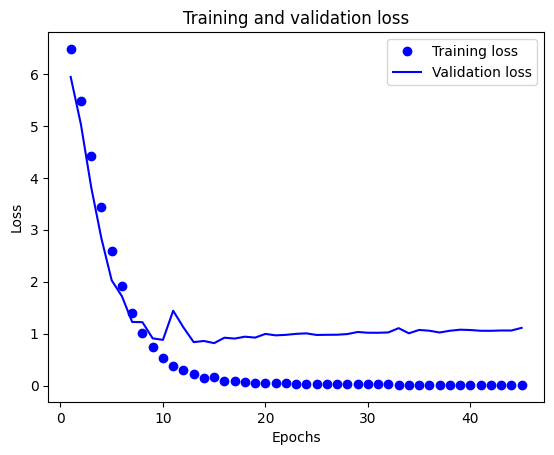

In [ ]:
plot_loss(history5)

The graph showed overfitting

Test accuracy

In [ ]:
model1_loss, model1_acc = model5.evaluate(dataset_test)

print('mode15_acc:', model1_acc)

10/10 [==============================] - 2s 66ms/step - loss: 0.7753 - accuracy: 0.7988
mode15_acc: 0.798799991607666


## 3.5 Add Regularizations (dropout or L2 regularization)

### 3.5.1 Increase dropout rate to 0.7

In [ ]:
def create_model6():

  inputs = keras.Input(shape=(127,128,1))
  x = layers.Flatten()(inputs)

  for i in range(4):
    x = layers.Dense(1024, activation='relu')(x)

  x = layers.Dropout(0.7)(x) # dropout rate of 0.7

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model6 = create_model6()
model6.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 flatten_5 (Flatten)         (None, 16256)             0         
                                                                 
 dense_17 (Dense)            (None, 1024)              16647168  
                                                                 
 dense_18 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_19 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_20 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0   

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) # Early stop if val_loss sees no improvement

Train

In [ ]:
history6 = model6.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=150,
  callbacks=[callback]
)

Epoch 1/150
131/131 [==============================] - 26s 138ms/step - loss: 6.6190 - accuracy: 0.0030 - val_loss: 6.0144 - val_accuracy: 0.0118
Epoch 2/150
131/131 [==============================] - 11s 84ms/step - loss: 5.7803 - accuracy: 0.0167 - val_loss: 5.0371 - val_accuracy: 0.0523
Epoch 3/150
131/131 [==============================] - 11s 84ms/step - loss: 4.8957 - accuracy: 0.0563 - val_loss: 3.9610 - val_accuracy: 0.1470
Epoch 4/150
131/131 [==============================] - 11s 86ms/step - loss: 4.0327 - accuracy: 0.1352 - val_loss: 3.4961 - val_accuracy: 0.2251
Epoch 5/150
131/131 [==============================] - 12s 90ms/step - loss: 3.2227 - accuracy: 0.2504 - val_loss: 2.4988 - val_accuracy: 0.3914
Epoch 6/150
131/131 [==============================] - 11s 84ms/step - loss: 2.5000 - accuracy: 0.3815 - val_loss: 2.2011 - val_accuracy: 0.4557
Epoch 7/150
131/131 [==============================] - 12s 88ms/step - loss: 1.9195 - accuracy: 0.4996 - val_loss: 1.4673 - val_a

Plot

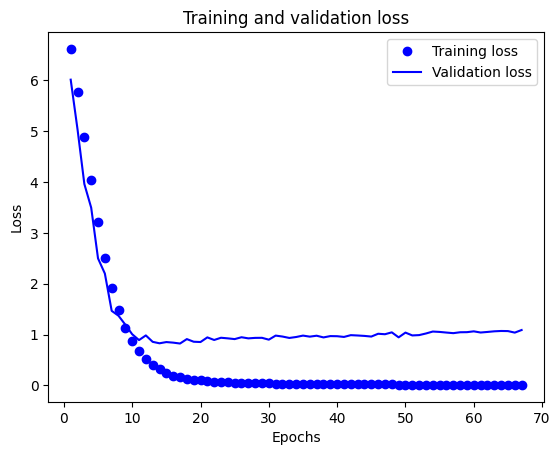

In [ ]:
plot_loss(history6)

Test accuracy

In [ ]:
model1_loss, model1_acc = model6.evaluate(dataset_test)

print('mode16_acc:', model1_acc)

10/10 [==============================] - 2s 59ms/step - loss: 0.8061 - accuracy: 0.8086
mode16_acc: 0.8086000084877014


### 3.5.2 L2 Regularization

Add L2 regularization with regularization factor of 0.001, after the first dense layer, following a flatten layer.

In [ ]:
from keras import regularizers

def create_model7():

  inputs = keras.Input(shape=(127,128,1))
  x = layers.Flatten()(inputs)

  x = layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) # L2 Regularization

  for i in range(3):
    x = layers.Dense(1024, activation='relu')(x)

  x = layers.Dropout(0.7)(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model7 = create_model7()
model7.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 flatten_6 (Flatten)         (None, 16256)             0         
                                                                 
 dense_22 (Dense)            (None, 1024)              16647168  
                                                                 
 dense_23 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_24 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_25 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0   

Train

In [ ]:
history7 = model7.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=150,
  callbacks=[callback]
)

Epoch 1/150
131/131 [==============================] - 32s 147ms/step - loss: 7.6221 - accuracy: 0.0023 - val_loss: 6.5773 - val_accuracy: 0.0045
Epoch 2/150
131/131 [==============================] - 11s 86ms/step - loss: 6.2908 - accuracy: 0.0087 - val_loss: 5.5650 - val_accuracy: 0.0245
Epoch 3/150
131/131 [==============================] - 11s 85ms/step - loss: 5.5724 - accuracy: 0.0260 - val_loss: 4.9078 - val_accuracy: 0.0612
Epoch 4/150
131/131 [==============================] - 12s 91ms/step - loss: 4.9557 - accuracy: 0.0613 - val_loss: 4.2435 - val_accuracy: 0.1356
Epoch 5/150
131/131 [==============================] - 12s 88ms/step - loss: 4.4228 - accuracy: 0.1141 - val_loss: 3.9658 - val_accuracy: 0.1873
Epoch 6/150
131/131 [==============================] - 12s 92ms/step - loss: 3.9272 - accuracy: 0.1835 - val_loss: 3.5595 - val_accuracy: 0.2560
Epoch 7/150
131/131 [==============================] - 12s 93ms/step - loss: 3.4881 - accuracy: 0.2599 - val_loss: 3.0417 - val_a

Plot

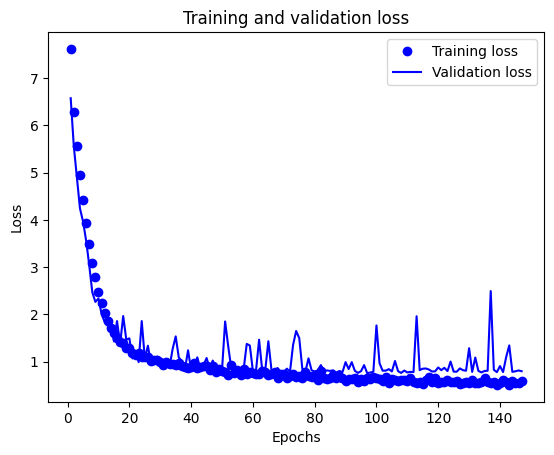

In [ ]:
plot_loss(history7)

Test accuracy

In [ ]:
model1_loss, model1_acc = model7.evaluate(dataset_test)

print('mode17_acc:', model1_acc)

10/10 [==============================] - 4s 62ms/step - loss: 0.7469 - accuracy: 0.9118
mode17_acc: 0.9118000268936157


The training had advanced and the test accuracy improved.

## 3.6 Add More layer

### 3.6.1 Five hidden dense layers (with dropout + L2 regularization)

In [ ]:
def create_model8():

  inputs = keras.Input(shape=(127,128,1))
  x = layers.Flatten()(inputs)

  x = layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) # L2 regularization

  for i in range(4):
    x = layers.Dense(1024, activation='relu')(x)

  x = layers.Dropout(0.7)(x) # dropout

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model8 = create_model8()
model8.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 flatten_7 (Flatten)         (None, 16256)             0         
                                                                 
 dense_27 (Dense)            (None, 1024)              16647168  
                                                                 
 dense_28 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_29 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_30 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_31 (Dense)            (None, 1024)              1049

Train

In [ ]:
history8 = model8.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=150,
  callbacks=[callback],
)

Epoch 1/150
131/131 [==============================] - 31s 163ms/step - loss: 7.6684 - accuracy: 0.0017 - val_loss: 6.7823 - val_accuracy: 0.0017
Epoch 2/150
131/131 [==============================] - 12s 87ms/step - loss: 6.5174 - accuracy: 0.0045 - val_loss: 6.0994 - val_accuracy: 0.0086
Epoch 3/150
131/131 [==============================] - 15s 110ms/step - loss: 5.8921 - accuracy: 0.0123 - val_loss: 5.5130 - val_accuracy: 0.0226
Epoch 4/150
131/131 [==============================] - 11s 84ms/step - loss: 5.4312 - accuracy: 0.0263 - val_loss: 4.9381 - val_accuracy: 0.0492
Epoch 5/150
131/131 [==============================] - 13s 95ms/step - loss: 5.0040 - accuracy: 0.0491 - val_loss: 4.4202 - val_accuracy: 0.1010
Epoch 6/150
131/131 [==============================] - 12s 87ms/step - loss: 4.5819 - accuracy: 0.0852 - val_loss: 4.0827 - val_accuracy: 0.1426
Epoch 7/150
131/131 [==============================] - 11s 84ms/step - loss: 4.2034 - accuracy: 0.1293 - val_loss: 4.2676 - val_

Plot

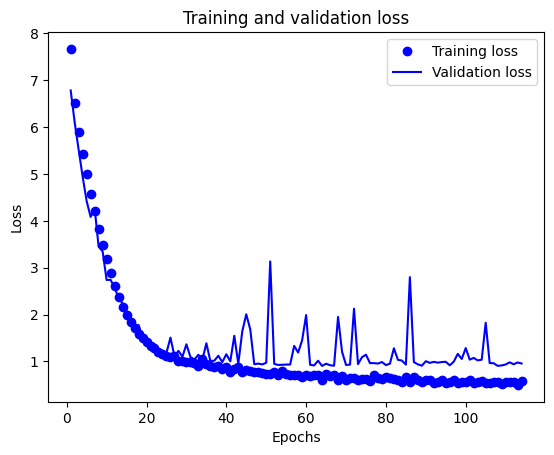

In [ ]:
plot_loss(history8)

Test accuracy

In [ ]:
model1_loss, model1_acc = model8.evaluate(dataset_test)

print('mode18_acc:', model1_acc)

10/10 [==============================] - 2s 64ms/step - loss: 0.9060 - accuracy: 0.8773
mode18_acc: 0.8773000240325928


This model didn't show progress in the accuracy of the test.

## 3.7 Add Other regularization (L1 regularization, Batch normalization, dropout rate of 0.9)

Model 8 was not better than Model 7 in the accuracy of the test. Several regularizations were implemented to see whether they improved the model 8.

### 3.7.1 L1 regularization

L1 regularization with regularization factor of 0.001 was used, after the first dense layer, following a flatten layer, instead of L2 regularization.

In [ ]:
from keras import regularizers

def create_model9():

  inputs = keras.Input(shape=(127,128,1))
  x = layers.Flatten()(inputs)

  x = layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x) # L1 regularization

  for i in range(4):
    x = layers.Dense(1024, activation='relu')(x)

  x = layers.Dropout(0.7)(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model9 = create_model9()
model9.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 127, 128, 1)]     0         
                                                                 
 flatten_8 (Flatten)         (None, 16256)             0         
                                                                 
 dense_33 (Dense)            (None, 1024)              16647168  
                                                                 
 dense_34 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_35 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_36 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_37 (Dense)            (None, 1024)              1049

Train

In [ ]:
history9 = model9.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=150,
  callbacks=[callback]
)

Epoch 1/150
131/131 [==============================] - 28s 144ms/step - loss: 127.0265 - accuracy: 9.9316e-04 - val_loss: 84.8569 - val_accuracy: 5.0000e-04
Epoch 2/150
131/131 [==============================] - 11s 85ms/step - loss: 84.8829 - accuracy: 9.2595e-04 - val_loss: 84.3009 - val_accuracy: 0.0011
Epoch 3/150
131/131 [==============================] - 12s 88ms/step - loss: 85.6995 - accuracy: 9.7076e-04 - val_loss: 87.0832 - val_accuracy: 6.0000e-04
Epoch 4/150
131/131 [==============================] - 11s 85ms/step - loss: 86.1684 - accuracy: 9.4836e-04 - val_loss: 85.2239 - val_accuracy: 4.0000e-04
Epoch 5/150
131/131 [==============================] - 11s 85ms/step - loss: 86.3702 - accuracy: 9.1849e-04 - val_loss: 87.5178 - val_accuracy: 4.0000e-04
Epoch 6/150
131/131 [==============================] - 11s 82ms/step - loss: 86.5027 - accuracy: 9.5582e-04 - val_loss: 85.4734 - val_accuracy: 7.0000e-04
Epoch 7/150
131/131 [==============================] - 11s 82ms/step - l

KeyboardInterrupt: 

The training was hardly progressing. So, the training was halted in the middle.

### 3.7.2 Batch normalization


batch nomalization every between Dense layer and Activation function, except the last dense layer with 956 units.

In [ ]:
def create_model10():

  inputs = keras.Input(shape=(127,128,1))
  x = layers.Flatten()(inputs)

  for i in range(5):
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x) # batch normalization
    x = layers.Activation("relu")(x)

  x = layers.Dropout(0.7)(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model10 = create_model10()
model10.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 127, 128, 1)]     0         
                                                                 
 flatten_9 (Flatten)         (None, 16256)             0         
                                                                 
 dense_39 (Dense)            (None, 1024)              16647168  
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_40 (Dense)            (None, 1024)              1049600   
                                                           

Train

In [ ]:
history10 = model10.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=150,
  callbacks=[callback]
)

Epoch 1/150
131/131 [==============================] - 35s 167ms/step - loss: 5.0736 - accuracy: 0.1048 - val_loss: 3.8168 - val_accuracy: 0.3042
Epoch 2/150
131/131 [==============================] - 14s 104ms/step - loss: 2.3966 - accuracy: 0.4375 - val_loss: 1.7060 - val_accuracy: 0.5868
Epoch 3/150
131/131 [==============================] - 12s 88ms/step - loss: 1.4047 - accuracy: 0.6375 - val_loss: 1.0747 - val_accuracy: 0.7253
Epoch 4/150
131/131 [==============================] - 12s 92ms/step - loss: 0.9449 - accuracy: 0.7468 - val_loss: 0.8270 - val_accuracy: 0.7781
Epoch 5/150
131/131 [==============================] - 12s 87ms/step - loss: 0.6811 - accuracy: 0.8120 - val_loss: 0.7234 - val_accuracy: 0.8020
Epoch 6/150
131/131 [==============================] - 12s 90ms/step - loss: 0.5085 - accuracy: 0.8562 - val_loss: 0.6458 - val_accuracy: 0.8244
Epoch 7/150
131/131 [==============================] - 12s 89ms/step - loss: 0.3950 - accuracy: 0.8865 - val_loss: 0.5993 - val_

Plot

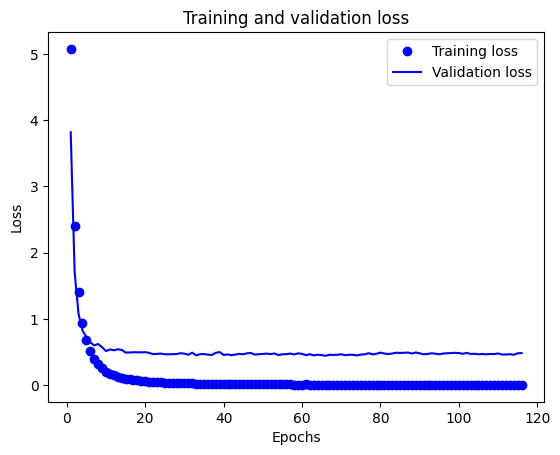

In [ ]:
plot_loss(history10)

Test accuracy

In [ ]:
model1_loss, model1_acc = model10.evaluate(dataset_test)

print('mode110_acc:', model1_acc)

10/10 [==============================] - 2s 58ms/step - loss: 0.4581 - accuracy: 0.8964
mode110_acc: 0.896399974822998


### 3.7.3 Dropout rate of 0.9 (+ batch normalization)

In [ ]:
def create_model11():

  inputs = keras.Input(shape=(127,128,1))
  x = layers.Flatten()(inputs)

  for i in range(5):
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x) # batch normalization
    x = layers.Activation("relu")(x)

  x = layers.Dropout(0.9)(x) # dropout rate of 0.9

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model11 = create_model11()
model11.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 127, 128, 1)]     0         
                                                                 
 flatten_10 (Flatten)        (None, 16256)             0         
                                                                 
 dense_45 (Dense)            (None, 1024)              16647168  
                                                                 
 batch_normalization_5 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 1024)              0         
                                                                 
 dense_46 (Dense)            (None, 1024)              1049600   
                                                          

Train

In [ ]:
history11 = model11.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=200,
  callbacks=[callback]
)

Epoch 1/200
131/131 [==============================] - 37s 179ms/step - loss: 6.9546 - accuracy: 0.0065 - val_loss: 6.0064 - val_accuracy: 0.0547
Epoch 2/200
131/131 [==============================] - 12s 86ms/step - loss: 5.3128 - accuracy: 0.0522 - val_loss: 4.1033 - val_accuracy: 0.2308
Epoch 3/200
131/131 [==============================] - 12s 87ms/step - loss: 4.0066 - accuracy: 0.1631 - val_loss: 2.8915 - val_accuracy: 0.3689
Epoch 4/200
131/131 [==============================] - 12s 87ms/step - loss: 3.0358 - accuracy: 0.2964 - val_loss: 1.7812 - val_accuracy: 0.5863
Epoch 5/200
131/131 [==============================] - 11s 85ms/step - loss: 2.3583 - accuracy: 0.4189 - val_loss: 1.4983 - val_accuracy: 0.6321
Epoch 6/200
131/131 [==============================] - 11s 86ms/step - loss: 1.8954 - accuracy: 0.5157 - val_loss: 1.2226 - val_accuracy: 0.6864
Epoch 7/200
131/131 [==============================] - 11s 86ms/step - loss: 1.5623 - accuracy: 0.5903 - val_loss: 0.9399 - val_a

Plot

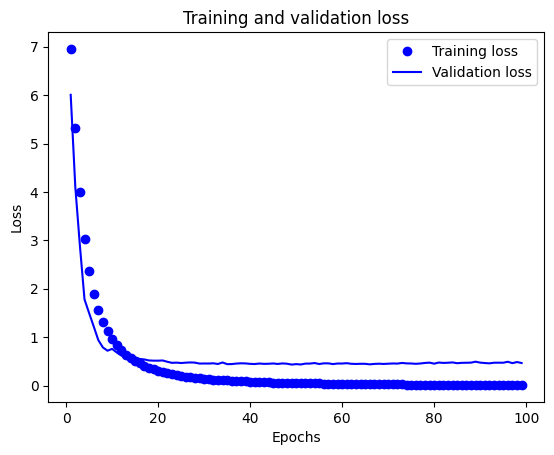

In [ ]:
plot_loss(history11)

Test accuracy

In [ ]:
model1_loss, model1_acc = model11.evaluate(dataset_test)

print('mode111_acc:', model1_acc)

10/10 [==============================] - 2s 62ms/step - loss: 0.4457 - accuracy: 0.8880
mode111_acc: 0.8880000114440918


## 3.8 Change activation function or Optimizer ("gelu", "adam")

Among the models with 5 dense layers, model 10 scored the highest accuracy on the test. Based on the model 10, models with Gaussian Error Linear Unit ('gelu') activation function or Adaptive Moment Estimation ('adam') optimizer were tested.

### 3.8.1 Gaussian Error Linear Unit ('gelu') as activation function

In [ ]:
def create_model12():

  inputs = keras.Input(shape=(127,128,1))
  x = layers.Flatten()(inputs)

  for i in range(5):
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x) # batch normalization
    x = layers.Activation("gelu")(x) # gelu

  x = layers.Dropout(0.7)(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model12 = create_model12()
model12.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 127, 128, 1)]     0         
                                                                 
 flatten_11 (Flatten)        (None, 16256)             0         
                                                                 
 dense_51 (Dense)            (None, 1024)              16647168  
                                                                 
 batch_normalization_10 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 1024)              0         
                                                                 
 dense_52 (Dense)            (None, 1024)              1049600   
                                                          

Train

In [ ]:
history12 = model12.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=200,
  callbacks=[callback]
)

Epoch 1/200
131/131 [==============================] - 38s 165ms/step - loss: 4.7502 - accuracy: 0.1451 - val_loss: 4.0354 - val_accuracy: 0.2265
Epoch 2/200
131/131 [==============================] - 13s 99ms/step - loss: 2.0359 - accuracy: 0.5175 - val_loss: 1.2368 - val_accuracy: 0.7082
Epoch 3/200
131/131 [==============================] - 12s 89ms/step - loss: 1.1594 - accuracy: 0.7030 - val_loss: 0.8761 - val_accuracy: 0.7715
Epoch 4/200
131/131 [==============================] - 13s 95ms/step - loss: 0.7626 - accuracy: 0.7972 - val_loss: 0.7468 - val_accuracy: 0.8009
Epoch 5/200
131/131 [==============================] - 14s 103ms/step - loss: 0.5411 - accuracy: 0.8518 - val_loss: 0.6844 - val_accuracy: 0.8117
Epoch 6/200
131/131 [==============================] - 12s 90ms/step - loss: 0.3965 - accuracy: 0.8904 - val_loss: 0.5896 - val_accuracy: 0.8358
Epoch 7/200
131/131 [==============================] - 12s 90ms/step - loss: 0.2981 - accuracy: 0.9168 - val_loss: 0.5769 - val_

Plot

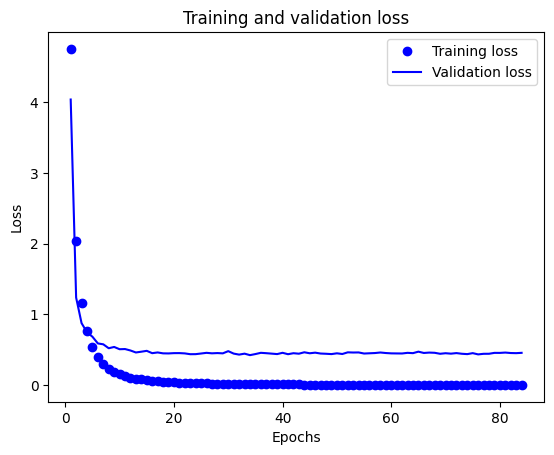

In [ ]:
plot_loss(history12)

Test accuracy

In [ ]:
model1_loss, model1_acc = model12.evaluate(dataset_test)

print('mode112_acc:', model1_acc)

10/10 [==============================] - 3s 61ms/step - loss: 0.4208 - accuracy: 0.8939
mode112_acc: 0.8938999772071838


### 3.8.2 Adaptive Moment Estimation ('adam') optimizer

In [ ]:
def create_model13():

  inputs = keras.Input(shape=(127,128,1))
  x = layers.Flatten()(inputs)

  for i in range(5):
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x) # batch nomalization
    x = layers.Activation("relu")(x) # relu

  x = layers.Dropout(0.7)(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='adam', # adam
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model13 = create_model13()
model13.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 127, 128, 1)]     0         
                                                                 
 flatten_12 (Flatten)        (None, 16256)             0         
                                                                 
 dense_57 (Dense)            (None, 1024)              16647168  
                                                                 
 batch_normalization_15 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 1024)              0         
                                                                 
 dense_58 (Dense)            (None, 1024)              1049600   
                                                          

Train

In [ ]:
history13 = model13.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=200,
  callbacks=[callback]
)

Epoch 1/200
131/131 [==============================] - 38s 163ms/step - loss: 5.3958 - accuracy: 0.0772 - val_loss: 3.8866 - val_accuracy: 0.3562
Epoch 2/200
131/131 [==============================] - 13s 102ms/step - loss: 2.5137 - accuracy: 0.4157 - val_loss: 1.6769 - val_accuracy: 0.6184
Epoch 3/200
131/131 [==============================] - 11s 86ms/step - loss: 1.4095 - accuracy: 0.6388 - val_loss: 1.1580 - val_accuracy: 0.7055
Epoch 4/200
131/131 [==============================] - 11s 86ms/step - loss: 0.9237 - accuracy: 0.7493 - val_loss: 0.8287 - val_accuracy: 0.7784
Epoch 5/200
131/131 [==============================] - 12s 92ms/step - loss: 0.6532 - accuracy: 0.8181 - val_loss: 0.7403 - val_accuracy: 0.8025
Epoch 6/200
131/131 [==============================] - 12s 91ms/step - loss: 0.4790 - accuracy: 0.8638 - val_loss: 0.6848 - val_accuracy: 0.8175
Epoch 7/200
131/131 [==============================] - 12s 89ms/step - loss: 0.3721 - accuracy: 0.8924 - val_loss: 0.6455 - val_

Plot

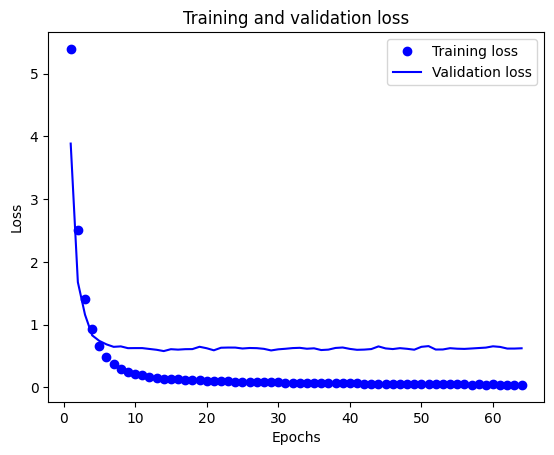

In [ ]:
plot_loss(history13)

Test accuracy

In [ ]:
model1_loss, model1_acc = model13.evaluate(dataset_test)

print('mode113_acc:', model1_acc)

10/10 [==============================] - 3s 64ms/step - loss: 0.5603 - accuracy: 0.8542
mode113_acc: 0.854200005531311


## 3.9 Reduce layer (model 7 + batch normalization)

The models with 5 hidden dense layers didn't beat model 7 with 4 hidden layers. Batch normalization was applied to model 7, instead of L2 regularization.

In [ ]:
def create_model14():

  inputs = keras.Input(shape=(127,128,1))
  x = layers.Flatten()(inputs)

  for i in range(4):
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x) # batch normalization
    x = layers.Activation("relu")(x)

  x = layers.Dropout(0.7)(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model14 = create_model14()
model14.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 127, 128, 1)]     0         
                                                                 
 flatten_13 (Flatten)        (None, 16256)             0         
                                                                 
 dense_63 (Dense)            (None, 1024)              16647168  
                                                                 
 batch_normalization_20 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 1024)              0         
                                                                 
 dense_64 (Dense)            (None, 1024)              1049600   
                                                          

Train

In [ ]:
history14 = model14.fit(
  dataset_train,
  validation_data=dataset_val,
  epochs=200,
  callbacks=[callback]
)

Epoch 1/200
131/131 [==============================] - 35s 166ms/step - loss: 4.9628 - accuracy: 0.1202 - val_loss: 3.6351 - val_accuracy: 0.4299
Epoch 2/200
131/131 [==============================] - 13s 95ms/step - loss: 2.3393 - accuracy: 0.4569 - val_loss: 1.5626 - val_accuracy: 0.6553
Epoch 3/200
131/131 [==============================] - 12s 87ms/step - loss: 1.4175 - accuracy: 0.6418 - val_loss: 1.1051 - val_accuracy: 0.7213
Epoch 4/200
131/131 [==============================] - 11s 86ms/step - loss: 0.9681 - accuracy: 0.7446 - val_loss: 0.9429 - val_accuracy: 0.7568
Epoch 5/200
131/131 [==============================] - 12s 89ms/step - loss: 0.7138 - accuracy: 0.8054 - val_loss: 0.7352 - val_accuracy: 0.8002
Epoch 6/200
131/131 [==============================] - 12s 89ms/step - loss: 0.5406 - accuracy: 0.8488 - val_loss: 0.6813 - val_accuracy: 0.8179
Epoch 7/200
131/131 [==============================] - 12s 93ms/step - loss: 0.4188 - accuracy: 0.8809 - val_loss: 0.6454 - val_a

Plot

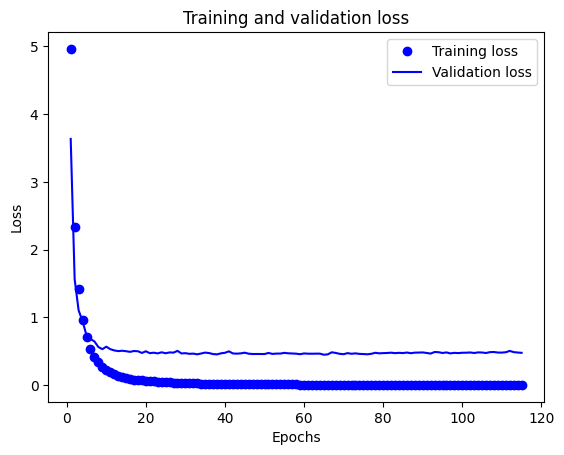

In [ ]:
plot_loss(history14)

Test accuracy

In [ ]:
model1_loss, model1_acc = model14.evaluate(dataset_test)

print('mode114_acc:', model1_acc)

10/10 [==============================] - 2s 61ms/step - loss: 0.4292 - accuracy: 0.8984
mode114_acc: 0.8984000086784363


## 3.10 Train the best model with "training + validation" dataset

So far, the model 7 had performed the best accuracy on the test data among all Dense models. The model 15 has the same structure as of the model 7. Finally, Train the model 15 with the 'training + validation' dataset for 108 epochs, as indicated by the best epoch during model 7's training."

In [ ]:
def create_model15():

  inputs = keras.Input(shape=(127,128,1))
  x = layers.Flatten()(inputs)

  x = layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

  for i in range(3):
    x = layers.Dense(1024, activation='relu')(x)

  x = layers.Dropout(0.7)(x)

  outputs = layers.Dense(956, activation='softmax')(x)

  # create a model
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
  )

  return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model15 = create_model15()
model15.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 127, 128, 1)]     0         
                                                                 
 flatten_16 (Flatten)        (None, 16256)             0         
                                                                 
 dense_78 (Dense)            (None, 1024)              16647168  
                                                                 
 dense_79 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_80 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_81 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0  

Train

In [ ]:
history15 = model15.fit(
  dataset_train_val, # train + validation
  epochs=108 # best epoch of the model 7 training
)

Epoch 1/108
141/141 [==============================] - 83s 503ms/step - loss: 7.5483 - accuracy: 0.0026
Epoch 2/108
141/141 [==============================] - 9s 66ms/step - loss: 6.1405 - accuracy: 0.0120
Epoch 3/108
141/141 [==============================] - 10s 67ms/step - loss: 5.4054 - accuracy: 0.0337
Epoch 4/108
141/141 [==============================] - 9s 66ms/step - loss: 4.7867 - accuracy: 0.0776
Epoch 5/108
141/141 [==============================] - 10s 66ms/step - loss: 4.2048 - accuracy: 0.1479
Epoch 6/108
141/141 [==============================] - 10s 67ms/step - loss: 3.6649 - accuracy: 0.2339
Epoch 7/108
141/141 [==============================] - 9s 65ms/step - loss: 3.2086 - accuracy: 0.3215
Epoch 8/108
141/141 [==============================] - 9s 66ms/step - loss: 2.8416 - accuracy: 0.3998
Epoch 9/108
141/141 [==============================] - 9s 66ms/step - loss: 2.5049 - accuracy: 0.4754
Epoch 10/108
141/141 [==============================] - 10s 66ms/step - loss:

Test accuracy

In [ ]:
model1_loss, model1_acc = model15.evaluate(dataset_test)

print('mode115_acc:', model1_acc)

10/10 [==============================] - 6s 139ms/step - loss: 0.8073 - accuracy: 0.8976
mode115_acc: 0.897599995136261
